# Behaviour Cloning Evaluation

In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
from typing import List

if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount( "/content/drive")
  if os.path.isdir('drive/MyDrive/Projects/Offline_RL_BSc_Thesis/notebooks'):
    os.chdir('drive/MyDrive/Projects/Offline_RL_BSc_Thesis/notebooks')


project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)

torch_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Test Evaluation

In [2]:
from src.utils.experiments import prepare_data
from src.normalization import NormalizationModule
from src.datasets import BCDataset
from src.utils.plotting import plot_confusion_matrix_heatmap

from torch.utils.data import DataLoader
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

C:\Users\Miro\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def print_model_eval_results(results: dict,
                             model_name: str = 'Replay Buffer') -> None:
    print('=' * 100)
    print(f'Model Evaluation results of {model_name}')

    for key, value in results.items():
        if isinstance(value, (list, tuple, np.ndarray)):
            print(f'{key}: {np.array(value)}')
        elif isinstance(value, dict):
            print(f'{key}:')
            for sub_key, sub_val in value.items():
                print(f'  {sub_key}: {sub_val}')
        else:
            print(f'{key}: {value}')

In [4]:
from typing import Tuple


def evaluate_model_test_dataset(model: torch.nn.Module,
                                device: torch.device,
                                test_df: pd.DataFrame,
                                norm_technique_script: NormalizationModule,
                                selected_features: List[str]) -> Tuple[dict, np.array]:
    model.eval()
    model.to(device)

    # Prepare normalized and filtered test data
    X_test, y_test = prepare_data(df=test_df,
                                  selected_features=selected_features,
                                  norm_script=norm_technique_script)

    test_dataset = BCDataset(states=X_test, actions=y_test)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for states, labels in test_loader:
            states, labels = states.to(device), labels.to(device)
            logits = model(states)
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    results = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "confusion_matrix": cm,
        "classification_report": class_report
    }

    return results, np.array(cm)

### Replay Buffer

In [5]:
rb_test_df = pd.read_parquet('../data/replay_buffer_episodes/rb_test.parquet').drop(columns=['done', 'episode'])
rb_normalization_technique = torch.jit.load('../models/replay_buffer/normalization/standard_normalization.pt')
rb_model = torch.jit.load('../models/replay_buffer/BC_standard_refined.pt')


rb_classificiation_repport_dict, rb_confusion_matrix = evaluate_model_test_dataset(model=rb_model,
                            device=torch_device,
                            test_df=rb_test_df,
                            norm_technique_script=rb_normalization_technique,
                            selected_features=['X', 'Y', 'lv_X', 'lv_Y', 'reward', 'angle', 'angular_velocity', 'leg_1', 'leg_2'])
print_model_eval_results(rb_classificiation_repport_dict,
                         model_name='BC Replay Buffer')

Model Evaluation results of BC Replay Buffer
accuracy: 0.5887092821503142
balanced_accuracy: 0.5891766647181432
precision_macro: 0.5156121821357602
recall_macro: 0.5891766647181432
f1_macro: 0.5172053144836699
precision_weighted: 0.7093929326363385
recall_weighted: 0.5887092821503142
f1_weighted: 0.6210704773761083
precision_per_class: [0.55189678 0.30887554 0.92087411 0.28080229]
recall_per_class: [0.53904604 0.58807183 0.60637734 0.62321145]
f1_per_class: [0.54539573 0.40502043 0.73124461 0.38716049]
confusion_matrix: [[14330  5121  1130  6003]
 [ 1453  5502   961  1440]
 [ 8359  6318 34344  7617]
 [ 1823   872   860  5880]]
classification_report:
  0: {'precision': 0.551896784132486, 'recall': 0.5390460427324707, 'f1-score': 0.5453957258939276, 'support': 26584.0}
  1: {'precision': 0.30887554033570985, 'recall': 0.5880718255664814, 'f1-score': 0.40502042769332697, 'support': 9356.0}
  2: {'precision': 0.9208741118112348, 'recall': 0.6063773438327624, 'f1-score': 0.7312446105202645,

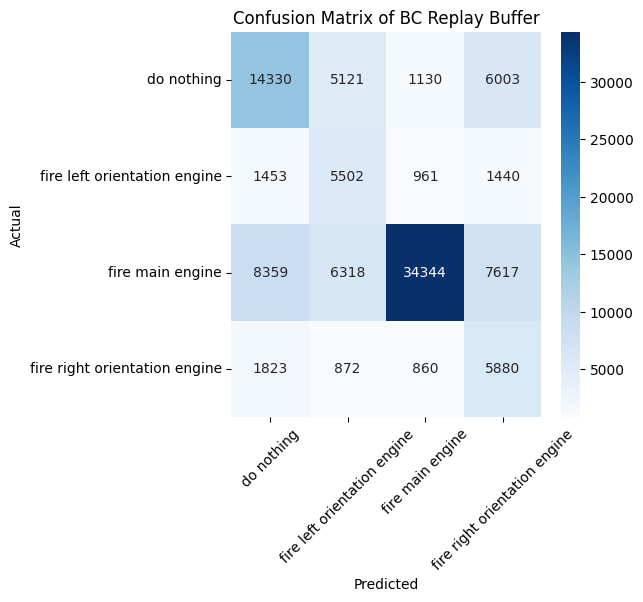

In [6]:
rb_confusion_matrix_fig = plot_confusion_matrix_heatmap(confusion_matrix=rb_confusion_matrix,
                                                        model_name='BC Replay Buffer',
                                                        f_size=(5,5))

### Final Policy

In [7]:
fp_test_df = pd.read_parquet('../data/final_policy_episodes/fp_test.parquet').drop(columns=['done', 'episode'])
fp_normalization_technique = torch.jit.load('../models/final_policy/normalization/standard_normalization.pt')
fp_model = torch.jit.load('../models/final_policy/BC_standard_refined.pt')


fp_classificiation_repport_dict, fp_confusion_matrix = evaluate_model_test_dataset(model=fp_model,
                            device=torch_device,
                            test_df=fp_test_df,
                            norm_technique_script=fp_normalization_technique,
                            selected_features=['X', 'Y', 'lv_X', 'lv_Y', 'reward', 'angle', 'angular_velocity', 'leg_1', 'leg_2'])
print_model_eval_results(fp_classificiation_repport_dict,
                         model_name='BC Final Policy')

Model Evaluation results of BC Final Policy
accuracy: 0.9065051728488519
balanced_accuracy: 0.9328487110450876
precision_macro: 0.8033221480454353
recall_macro: 0.9328487110450876
f1_macro: 0.8528045910737406
precision_weighted: 0.9239602808037797
recall_weighted: 0.9065051728488519
f1_weighted: 0.9107081263730141
precision_per_class: [0.90650891 0.63735121 0.98973795 0.67969052]
recall_per_class: [0.89863507 0.96805336 0.89896804 0.96573837]
f1_per_class: [0.90255482 0.76864111 0.94217183 0.7978506 ]
confusion_matrix: [[30417  1501   465  1465]
 [   95  5515    16    71]
 [ 2938  1577 48609   948]
 [  104    60    23  5271]]
classification_report:
  0: {'precision': 0.9065089110091197, 'recall': 0.8986350744504845, 'f1-score': 0.902554820331741, 'support': 33848.0}
  1: {'precision': 0.6373512076736392, 'recall': 0.9680533614182903, 'f1-score': 0.7686411149825784, 'support': 5697.0}
  2: {'precision': 0.9897379512552684, 'recall': 0.8989680426098535, 'f1-score': 0.9421718273004798, 's

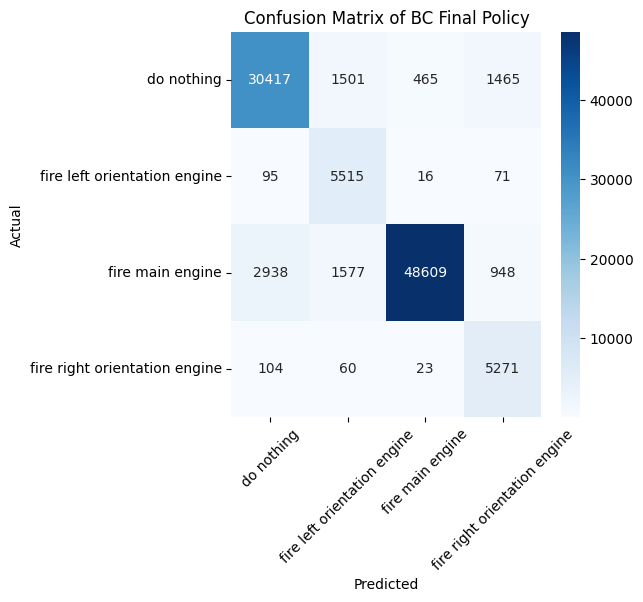

In [8]:
fp_confusion_matrix_fig = plot_confusion_matrix_heatmap(confusion_matrix=fp_confusion_matrix,
                                                        model_name='BC Final Policy',
                                                        f_size=(5,5))

## Evaluation in the Live Environment for 1000 episodes

In [9]:
import yaml
import warnings

from src.utils.live_env_testing import BC_evaluate_model_in_live_env

warnings.filterwarnings("ignore")
with open('../config/bc_live_env_elavuation_config.yaml', 'r') as f:
    bc_live_env_config_config = yaml.safe_load(f)

### Replay Buffer

In [10]:
rb_rewards = BC_evaluate_model_in_live_env(
    env_test_params=bc_live_env_config_config,
    model_name='replay_buffer',
    norm_technique=rb_normalization_technique,
    model = rb_model
)

100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


### Final Policy

In [11]:
fp_rewards = BC_evaluate_model_in_live_env(
    env_test_params=bc_live_env_config_config,
    norm_technique=fp_normalization_technique,
    model_name='final_policy',
    model = fp_model
)

100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


### Accumulated rewards distribution comparison

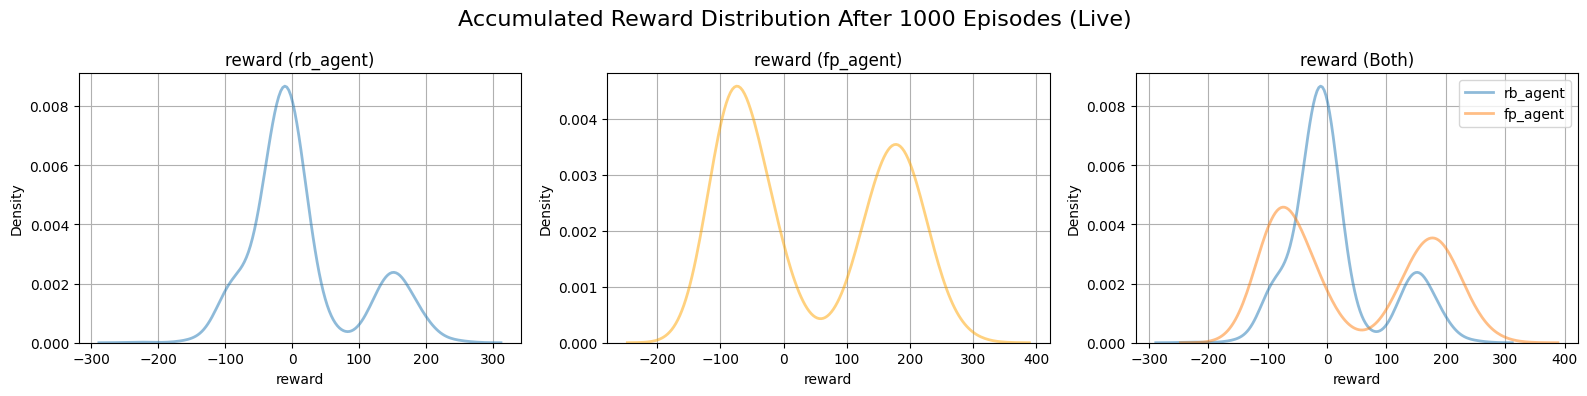

In [12]:
from src.utils.plotting import plot_univariate_analysis


rb_rewards_df = pd.DataFrame(rb_rewards, columns=['reward'])
fp_rewards_df = pd.DataFrame(fp_rewards, columns=['reward'])

rb_fp_combined_fig = plot_univariate_analysis(
        df1_name = 'rb_agent',
        df2_name = 'fp_agent',
        df1=rb_rewards_df,
        df2=fp_rewards_df,
        num_columns=3,
        custom_title='Accumulated Reward Distribution After 1000 Episodes (Live)',
        kde_kwargs={'linewidth': 2, 'alpha': 0.5},
        hist_kwargs={'alpha': 0.5, 'grid': True, 'bins': [-0.5, 0.5, 1.5, 2.5, 3.5],'align':'mid', 'rwidth': 0.8},
        f_size=(16,4))
rb_fp_combined_fig.savefig('../plots/liven_env_1000_ep_eval_rb_fp.jpg')